In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import sklearn
import h5py
import os
import getpass
import seaborn as sns
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, r2_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score


/Users/JundongQiao/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
% matplotlib inline

In [24]:
from sklearn.metrics import auc

In [226]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [94]:
import dill as pickle

### Import Data

In [227]:
# Import Data
DATA_DIR ='/Users/{}/Dropbox/VirtualBeach/Regression'.format(getpass.getuser())
train_eval_test = pd.read_csv(os.path.join(DATA_DIR, 'Woodlawn_2008_2018_16_features_target.csv'), header='infer', sep=',', index_col=0)
train_eval_test.reindex(range(len(train_eval_test)))

ecoli_threshold = 235.
X = train_eval_test.iloc[:,2:].copy()
y = train_eval_test.iloc[:,1].copy().apply(lambda x: 1 if x>np.log10(ecoli_threshold) else 0)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=456)
# X_train , X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.15, stratify=y_train_val, random_state=456)


In [248]:
# Oversampling using SMOTE
# # sm = BorderlineSMOTE(random_state=456, kind='borderline-1')
# sm = ADASYN(random_state=456)
sm = SMOTE(random_state=456)
X_res, y_res = sm.fit_sample(X_train_val, y_train_val) # return X_res, y_res as np.array
X_res_df = pd.DataFrame(data=X_res, columns = X_train_val.columns)
y_res_Series = pd.Series(data=y_res)

In [197]:
type(X_res)

numpy.ndarray

In [181]:
print ("%d samples before applying SMOTE" % X_train_val.shape[0])
print ("%d samples after applying SMOTE" % X_res_df.shape[0])

512 samples before applying SMOTE
707 samples after applying SMOTE


In [182]:
print sum(y_train_val)/float(len(y_train_val))
print sum(y_res)/float(len(y_res))

0.30859375
0.49929278642149927


In [183]:
pos_rate = sum(y)/float(len(y))
print ("Positive ratio: %0.4f" % pos_rate)

Positive ratio: 0.3089


### Esimators: XGB, DT, RandomForest

In [260]:
# XGB
xgb_with_SMOTE = XGBClassifier( 
                                learning_rate =0.1, 
                                 n_estimators=5000
                               , max_depth=5
                               , min_child_weight=1
                               , gamma=0.2
                               , subsample=0.8
                               , colsample_bytree=0.8
                               , reg_alpha=0.01
                               , reg_lambda=0.01
                               , objective= 'binary:logistic'
                               , n_jobs=4
                               , 
                                random_state=456)

# Decision Tree
rf_with_SMOTE = DecisionTreeClassifier(max_depth=5, random_state=456)

# Random Forest
rf_with_SMOTE = RandomForestClassifier(max_depth=5, random_state=456)

In [261]:
# Using Synthetic Data
xgb_with_SMOTE.fit(X_res_df, y_res_Series)
rf_with_SMOTE.fit(X_res_df, y_res_Series)
rf_with_SMOTE.fit(X_res_df, y_res_Series)

# Using Orignal Data
xgb_no_SMOTE.fit(X_train_val, y_train_val)
rf_no_SMOTE.fit(X_train_val, y_train_val)
rf_no_SMOTE.fit(X_train_val, y_train_val);

In [199]:
# Save models
pickle.dump(xgb_with_SMOTE, open("xgb_with_SMOTE.dat", "wb"))
pickle.dump(rf_with_SMOTE, open("rf_with_SMOTE.dat", "wb"))
pickle.dump(rf_with_SMOTE, open("rf_with_SMOTE.dat", "wb"))

pickle.dump(xgb_no_SMOTE, open("xgb_no_SMOTE.dat", "wb"))
pickle.dump(rf_no_SMOTE, open("rf_no_SMOTE.dat", "wb"))
pickle.dump(rf_no_SMOTE, open("rf_no_SMOTE.dat", "wb"))

In [256]:
def plot_prc(estimator, y_true, marker, color):
    
    clf = str(estimator).split(',')[0].split('(')[0]
    
    y_probs = estimator.predict_proba(X_test)
    y_probs = y_probs[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    # calculate precision-recall AUC
    auc_ = auc(recall, precision)
    
    # calculate average precision score
    ap = average_precision_score(y_true, y_probs, average='macro')
    
    print('%s: auc=%.3f ap=%.3f' % (clf, auc_, ap))
    
    # plot no skill
    plt.plot([0, 1], [pos_rate, pos_rate], linestyle='--')
    
    # plot the roc curve for the model
    plt.plot(recall, precision, marker=marker, color = color, label = clf)
    plt.xlim([0,1.01])
    plt.ylim([0,1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

XGBClassifier: auc=0.698 ap=0.704
RandomForestClassifier: auc=0.709 ap=0.713
DecisionTreeClassifier: auc=0.588 ap=0.586


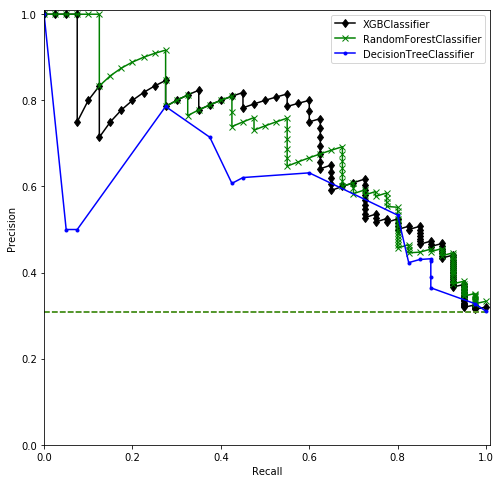

In [262]:
plt.figure(figsize = (8,8))
plot_prc(xgb_with_SMOTE, y_test, 'd' ,'k')
plot_prc(rf_with_SMOTE, y_test, 'x','g')
plot_prc(dt_with_SMOTE, y_test, '.' ,'b')

XGBClassifier: auc=0.642 ap=0.657
RandomForestClassifier: auc=0.705 ap=0.709
DecisionTreeClassifier: auc=0.597 ap=0.502


'\nXGBClassifier: auc=0.652 ap=0.660\nRandomForestClassifier: auc=0.713 ap=0.718\nDecisionTreeClassifier: auc=0.588 ap=0.586\n'

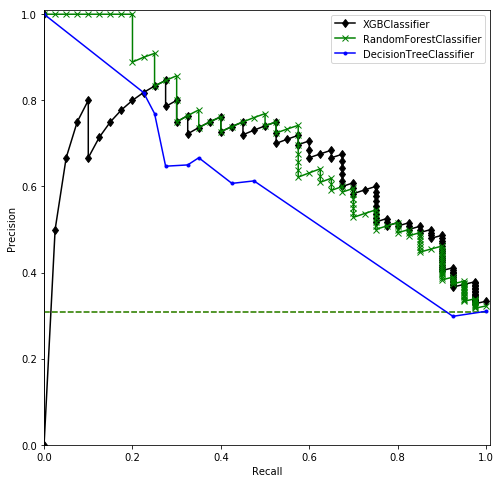

In [263]:
plt.figure(figsize = (8,8))
plot_prc(xgb_no_SMOTE, y_test, 'd' ,'k')
plot_prc(rf_no_SMOTE, y_test, 'x','g')
plot_prc(dt_no_SMOTE, y_test, '.' ,'b')
'''
XGBClassifier: auc=0.652 ap=0.660
RandomForestClassifier: auc=0.713 ap=0.718
DecisionTreeClassifier: auc=0.588 ap=0.586
'''

In [139]:
s.split(',')[0].split('(')[0]

'XGBClassifier'

In [87]:
y_preds = xgb_with_SMOTE.predict(X_test.values)

In [92]:
y_probs = xgb_with_SMOTE.predict_proba(X_test.values)

auc=0.637 ap=0.653


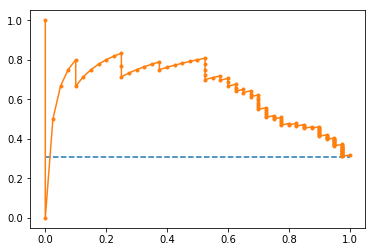

In [93]:
pos_rate = sum(y)/float(len(y))

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# calculate precision-recall AUC
auc_ = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, y_probs)
print('auc=%.3f ap=%.3f' % (auc_, ap))
# plot no skill
plt.plot([0, 1], [pos_rate, pos_rate], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')

In [ ]:
def plot_prc(clf, y_true)

auc=0.639 ap=0.655


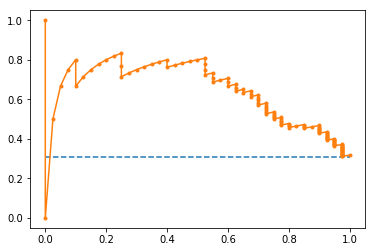

In [46]:
plot_prc(y_test, y_probs[:,1])

In [26]:
xgb_no_SMOTE = XGBClassifier( learning_rate =0.1
                               , n_estimators=2000
                               , max_depth=5
                               , min_child_weight=1
                               , gamma=0.2
                               , subsample=0.8
                               , colsample_bytree=0.8
                               , reg_alpha=0.01
                               , objective= 'binary:logistic'
                               , n_jobs=4
                               , random_state=456)
xgb_no_SMOTE.fit(X_train_val, y_train_val)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.2, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=2000, n_jobs=4, nthread=None,
       objective='binary:logistic', random_state=456, reg_alpha=0.01,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [27]:
y_preds_no = xgb_no_SMOTE.predict(X_test)

In [28]:
confusion_matrix(y_test, y_preds_no)

array([[80,  9],
       [18, 22]])

In [39]:
confusion_matrix(y_test, y_preds)

array([[74, 15],
       [14, 26]])

In [30]:
y_probs_no = xgb_no_SMOTE.predict_proba(X_test)

In [34]:
y_probs_no.shape

(129, 2)

In [82]:
def plot_prc(y_test, y_probs, c):
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    # calculate precision-recall AUC
    auc_ = auc(recall, precision)
    # calculate average precision score
    ap = average_precision_score(y_test, y_probs, average='weighted')
    print('auc=%.3f ap=%.3f' % (auc_, ap))
    # plot no skill
    plt.plot([0, 1], [pos_rate, pos_rate], linestyle='--')
    # plot the roc curve for the model
    plt.plot(recall, precision, marker='.', color = c)

auc=0.639 ap=0.655
auc=0.642 ap=0.657


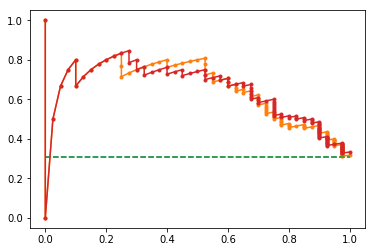

In [38]:
plot_prc(y_test, y_probs)
plot_prc(y_test, y_probs_no[:,1])

In [68]:
dt_with_SMOTE = DecisionTreeClassifier(max_depth=5, random_state=456)
dt_with_SMOTE.fit(X_res, y_res)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=456,
            splitter='best')

In [69]:
y_preds_dt_with = dt_with_SMOTE.predict(X_test)
y_probs_dt_with = dt_with_SMOTE.predict_proba(X_test)

In [70]:
confusion_matrix(y_test, y_preds_dt_with)

array([[61, 28],
       [ 8, 32]])

auc=0.639 ap=0.655
auc=0.642 ap=0.657
auc=0.588 ap=0.586


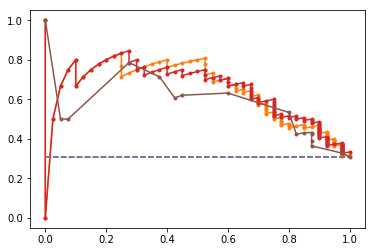

In [71]:
plot_prc(y_test, y_probs[:,1])
plot_prc(y_test, y_probs_no[:,1])
plot_prc(y_test, y_probs_dt_with[:,1])

In [72]:
dt_no_SMOTE = DecisionTreeClassifier(max_depth=5, random_state=456)
dt_no_SMOTE.fit(X_train_val, y_train_val)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=456,
            splitter='best')

In [73]:
y_preds_dt_no = dt_no_SMOTE.predict(X_test)
y_probs_dt_no = dt_no_SMOTE.predict_proba(X_test)

In [74]:
confusion_matrix(y_test, y_preds_dt_no)

array([[82,  7],
       [26, 14]])

auc=0.639 ap=0.655
auc=0.642 ap=0.657
auc=0.588 ap=0.586
auc=0.597 ap=0.502


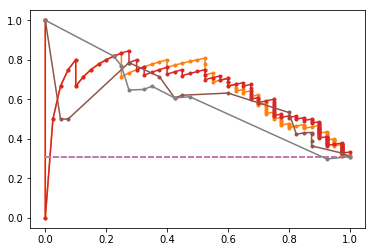

In [75]:
plot_prc(y_test, y_probs[:,1])
plot_prc(y_test, y_probs_no[:,1])
plot_prc(y_test, y_probs_dt_with[:,1])
plot_prc(y_test, y_probs_dt_no[:,1])

In [76]:
rf_with_SMOTE = RandomForestClassifier(n_estimators=2000, max_depth=5, random_state=456)
rf_with_SMOTE.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=456, verbose=0, warm_start=False)

In [77]:
rf_no_SMOTE = RandomForestClassifier(n_estimators=2000, max_depth=5, random_state=456)
rf_no_SMOTE.fit(X_train_val, y_train_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=456, verbose=0, warm_start=False)

In [78]:
y_preds_rf_with = rf_with_SMOTE.predict(X_test)
y_probs_rf_with = rf_with_SMOTE.predict_proba(X_test)

y_preds_rf_no = rf_no_SMOTE.predict(X_test)
y_probs_rf_no = rf_no_SMOTE.predict_proba(X_test)

In [79]:
confusion_matrix(y_test, y_preds_rf_with)

array([[74, 15],
       [12, 28]])

In [80]:
confusion_matrix(y_test, y_preds_rf_no)

array([[83,  6],
       [24, 16]])

auc=0.639 ap=0.655
auc=0.642 ap=0.657
auc=0.588 ap=0.586
auc=0.597 ap=0.502
auc=0.723 ap=0.726
auc=0.705 ap=0.709


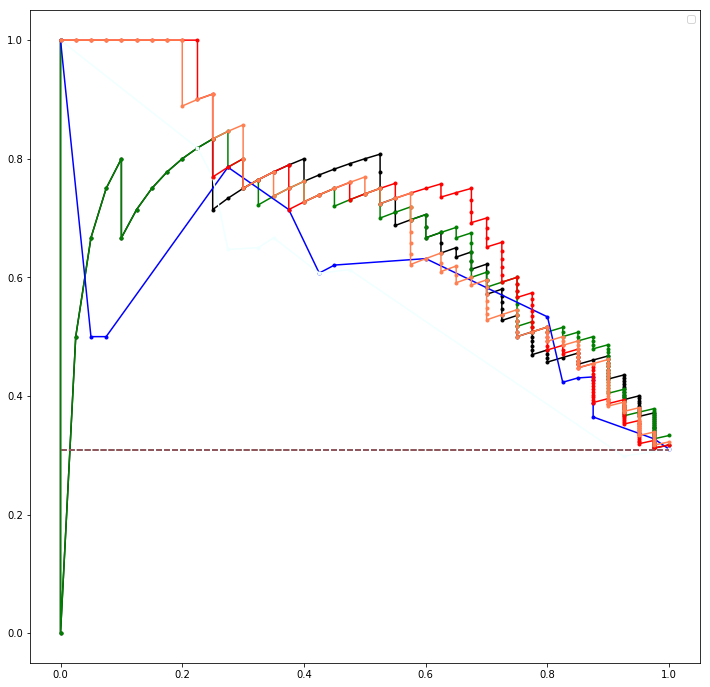

In [85]:
plt.figure(figsize=(12,12))
plot_prc(y_test, y_probs[:,1], 'k')
plot_prc(y_test, y_probs_no[:,1], 'g')
plot_prc(y_test, y_probs_dt_with[:,1], 'b')
plot_prc(y_test, y_probs_dt_no[:,1], 'azure')
plot_prc(y_test, y_probs_rf_with[:,1], 'r')
plot_prc(y_test, y_probs_rf_no[:,1], 'coral')
plt.legend()